# Company Research 


Conducting company research, or competitive analysis, is a critical part of any business strategy. In this notebook, we will demonstrate how to create a team of agents to address this task. While there are many ways to translate a task into an agentic implementation, we will explore a sequential approach. We will create agents corresponding to steps in the research process and give them tools to perform their tasks.

- **Search Agent**: Searches the web for information about a company. Will have access to a search engine API tool to retrieve search results.
- **Stock Analysis Agent**: Retrieves the company's stock information from a financial data API, computes basic statistics (current price, 52-week high, 52-week low, etc.), and generates a plot of the stock price year-to-date, saving it to a file. Will have access to a financial data API tool to retrieve stock information.
- **Report Agent**: Generates a report based on the information collected by the search and stock analysis agents. 

First, let's import the necessary modules.

In [6]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_core.tools import FunctionTool
from autogen_ext.models.openai import OpenAIChatCompletionClient

## Defining Tools 

Next, we will define the tools that the agents will use to perform their tasks. We will create a `google_search` that uses the Google Search API to search the web for information about a company. We will also create a  `analyze_stock` function that uses the `yfinance` library to retrieve stock information for a company. 

Finally, we will wrap these functions into a `FunctionTool` class that will allow us to use them as tools in our agents. 

Note: The `google_search` function requires an API key to work. You can create a `.env` file in the same directory as this notebook and add your API key as 

```
GOOGLE_SEARCH_ENGINE_ID =xxx
GOOGLE_API_KEY=xxx 
``` 

Also install required libraries 

```
pip install yfinance matplotlib pytz numpy pandas python-dotenv requests bs4
```

In [7]:
#!pip install yfinance matplotlib pytz numpy pandas python-dotenv requests bs4


def google_search(query: str, num_results: int = 2, max_chars: int = 500) -> list:  # type: ignore[type-arg]
    import os
    import time

    import requests
    from bs4 import BeautifulSoup
    from dotenv import load_dotenv

    load_dotenv()

    api_key = os.getenv("GOOGLE_API_KEY")
    search_engine_id = os.getenv("GOOGLE_SEARCH_ENGINE_ID")

    if not api_key or not search_engine_id:
        raise ValueError("API key or Search Engine ID not found in environment variables")

    url = "https://customsearch.googleapis.com/customsearch/v1"
    params = {"key": str(api_key), "cx": str(search_engine_id), "q": str(query), "num": str(num_results)}

    response = requests.get(url, params=params)

    if response.status_code != 200:
        print(response.json())
        raise Exception(f"Error in API request: {response.status_code}")

    results = response.json().get("items", [])

    def get_page_content(url: str) -> str:
        try:
            response = requests.get(url, timeout=10)
            soup = BeautifulSoup(response.content, "html.parser")
            text = soup.get_text(separator=" ", strip=True)
            words = text.split()
            content = ""
            for word in words:
                if len(content) + len(word) + 1 > max_chars:
                    break
                content += " " + word
            return content.strip()
        except Exception as e:
            print(f"Error fetching {url}: {str(e)}")
            return ""

    enriched_results = []
    for item in results:
        body = get_page_content(item["link"])
        enriched_results.append(
            {"title": item["title"], "link": item["link"], "snippet": item["snippet"], "body": body}
        )
        time.sleep(1)  # Be respectful to the servers

    return enriched_results


def analyze_stock(ticker: str) -> dict:  # type: ignore[type-arg]
    import os
    from datetime import datetime, timedelta

    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import yfinance as yf
    from pytz import timezone  # type: ignore

    stock = yf.Ticker(ticker)

    # Get historical data (1 year of data to ensure we have enough for 200-day MA)
    end_date = datetime.now(timezone("UTC"))
    start_date = end_date - timedelta(days=365)
    hist = stock.history(start=start_date, end=end_date)

    # Ensure we have data
    if hist.empty:
        return {"error": "No historical data available for the specified ticker."}

    # Compute basic statistics and additional metrics
    current_price = stock.info.get("currentPrice", hist["Close"].iloc[-1])
    year_high = stock.info.get("fiftyTwoWeekHigh", hist["High"].max())
    year_low = stock.info.get("fiftyTwoWeekLow", hist["Low"].min())

    # Calculate 50-day and 200-day moving averages
    ma_50 = hist["Close"].rolling(window=50).mean().iloc[-1]
    ma_200 = hist["Close"].rolling(window=200).mean().iloc[-1]

    # Calculate YTD price change and percent change
    ytd_start = datetime(end_date.year, 1, 1, tzinfo=timezone("UTC"))
    ytd_data = hist.loc[ytd_start:]  # type: ignore[misc]
    if not ytd_data.empty:
        price_change = ytd_data["Close"].iloc[-1] - ytd_data["Close"].iloc[0]
        percent_change = (price_change / ytd_data["Close"].iloc[0]) * 100
    else:
        price_change = percent_change = np.nan

    # Determine trend
    if pd.notna(ma_50) and pd.notna(ma_200):
        if ma_50 > ma_200:
            trend = "Upward"
        elif ma_50 < ma_200:
            trend = "Downward"
        else:
            trend = "Neutral"
    else:
        trend = "Insufficient data for trend analysis"

    # Calculate volatility (standard deviation of daily returns)
    daily_returns = hist["Close"].pct_change().dropna()
    volatility = daily_returns.std() * np.sqrt(252)  # Annualized volatility

    # Create result dictionary
    result = {
        "ticker": ticker,
        "current_price": current_price,
        "52_week_high": year_high,
        "52_week_low": year_low,
        "50_day_ma": ma_50,
        "200_day_ma": ma_200,
        "ytd_price_change": price_change,
        "ytd_percent_change": percent_change,
        "trend": trend,
        "volatility": volatility,
    }

    # Convert numpy types to Python native types for better JSON serialization
    for key, value in result.items():
        if isinstance(value, np.generic):
            result[key] = value.item()

    # Generate plot
    plt.figure(figsize=(12, 6))
    plt.plot(hist.index, hist["Close"], label="Close Price")
    plt.plot(hist.index, hist["Close"].rolling(window=50).mean(), label="50-day MA")
    plt.plot(hist.index, hist["Close"].rolling(window=200).mean(), label="200-day MA")
    plt.title(f"{ticker} Stock Price (Past Year)")
    plt.xlabel("Date")
    plt.ylabel("Price ($)")
    plt.legend()
    plt.grid(True)

    # Save plot to file
    os.makedirs("coding", exist_ok=True)
    plot_file_path = f"coding/{ticker}_stockprice.png"
    plt.savefig(plot_file_path)
    print(f"Plot saved as {plot_file_path}")
    result["plot_file_path"] = plot_file_path

    return result

In [8]:
google_search_tool = FunctionTool(
    google_search, description="Search Google for information, returns results with a snippet and body content"
)
stock_analysis_tool = FunctionTool(analyze_stock, description="Analyze stock data and generate a plot")

## Defining Agents

Next, we will define the agents that will perform the tasks. We will create a `search_agent` that searches the web for information about a company,  a `stock_analysis_agent` that retrieves stock information for a company, and a `report_agent` that generates a report based on the information collected by the other agents. 

In [9]:
search_agent = AssistantAgent(
    name="Google_Search_Agent",
    model_client=OpenAIChatCompletionClient(model="gpt-4o"),
    tools=[google_search_tool],
    description="Search Google for information, returns top 2 results with a snippet and body content",
    system_message="You are a helpful AI assistant. Solve tasks using your tools.",
)

stock_analysis_agent = AssistantAgent(
    name="Stock_Analysis_Agent",
    model_client=OpenAIChatCompletionClient(model="gpt-4o"),
    tools=[stock_analysis_tool],
    description="Analyze stock data and generate a plot",
    system_message="Perform data analysis.",
)

report_agent = AssistantAgent(
    name="Report_Agent",
    model_client=OpenAIChatCompletionClient(model="gpt-4o"),
    description="Generate a report based the search and results of stock analysis",
    system_message="You are a helpful assistant that can generate a comprehensive report on a given topic based on search and stock analysis. When you done with generating the report, reply with TERMINATE.",
)

## Creating the Team

Finally, let's create a team of the three agents and set them to work on researching a company.

In [10]:
team = RoundRobinGroupChat([stock_analysis_agent, search_agent, report_agent], max_turns=3)

We use `max_turns=3` to limit the number of turns to exactly the same number of agents in the team. This effectively makes the agents work in a sequential manner.

---------- user ----------
Write a financial report on American airlines
---------- Stock_Analysis_Agent ----------
[FunctionCall(id='call_tPh9gSfGrDu1nC2Ck5RlfbFY', arguments='{"ticker":"AAL"}', name='analyze_stock')]
[Prompt tokens: 64, Completion tokens: 16]
Plot saved as coding/AAL_stockprice.png
---------- Stock_Analysis_Agent ----------
[FunctionExecutionResult(content="{'ticker': 'AAL', 'current_price': 17.4, '52_week_high': 18.09, '52_week_low': 9.07, '50_day_ma': 13.376799983978271, '200_day_ma': 12.604399962425232, 'ytd_price_change': 3.9600000381469727, 'ytd_percent_change': 29.46428691803602, 'trend': 'Upward', 'volatility': 0.4461582174242901, 'plot_file_path': 'coding/AAL_stockprice.png'}", call_id='call_tPh9gSfGrDu1nC2Ck5RlfbFY')]
---------- Stock_Analysis_Agent ----------
Tool calls:
analyze_stock({"ticker":"AAL"}) = {'ticker': 'AAL', 'current_price': 17.4, '52_week_high': 18.09, '52_week_low': 9.07, '50_day_ma': 13.376799983978271, '200_day_ma': 12.604399962425232, 'yt

TaskResult(messages=[TextMessage(source='user', models_usage=None, content='Write a financial report on American airlines', type='TextMessage'), ToolCallRequestEvent(source='Stock_Analysis_Agent', models_usage=RequestUsage(prompt_tokens=64, completion_tokens=16), content=[FunctionCall(id='call_tPh9gSfGrDu1nC2Ck5RlfbFY', arguments='{"ticker":"AAL"}', name='analyze_stock')], type='ToolCallRequestEvent'), ToolCallExecutionEvent(source='Stock_Analysis_Agent', models_usage=None, content=[FunctionExecutionResult(content="{'ticker': 'AAL', 'current_price': 17.4, '52_week_high': 18.09, '52_week_low': 9.07, '50_day_ma': 13.376799983978271, '200_day_ma': 12.604399962425232, 'ytd_price_change': 3.9600000381469727, 'ytd_percent_change': 29.46428691803602, 'trend': 'Upward', 'volatility': 0.4461582174242901, 'plot_file_path': 'coding/AAL_stockprice.png'}", call_id='call_tPh9gSfGrDu1nC2Ck5RlfbFY')], type='ToolCallExecutionEvent'), TextMessage(source='Stock_Analysis_Agent', models_usage=None, content

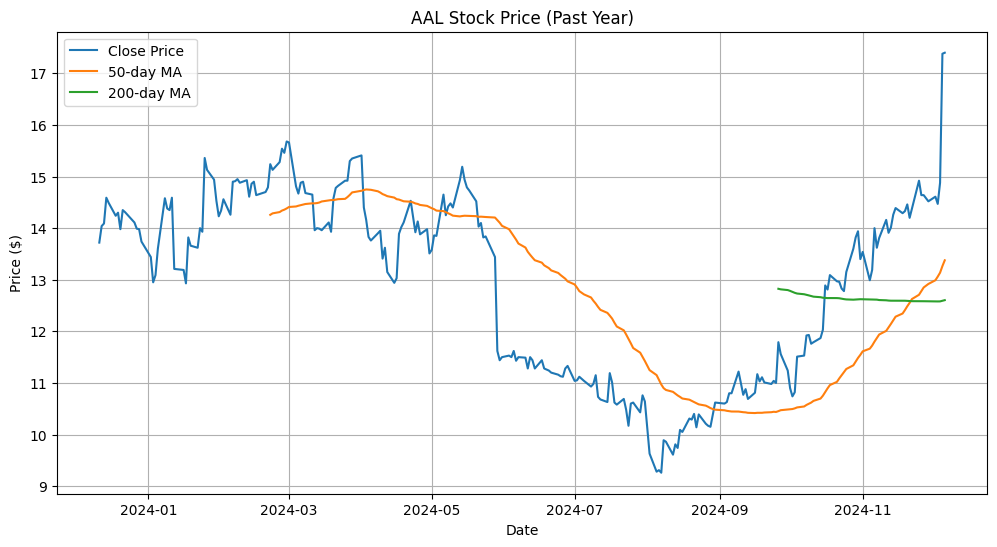

In [11]:
stream = team.run_stream(task="Write a financial report on American airlines")
await Console(stream)